# 00 Install Dependecies

In [ ]:
!pip install cv2

In [ ]:
!pip install numpy

In [ ]:
!pip install pandas

In [ ]:
!pip install matplotlib

# 00 Initial Setting

In [1]:
# For image processing
import cv2
import imutils
import numpy as np
import pandas as pd

# For Math
import math
from scipy.stats import norm
from scipy.spatial import cKDTree

# For path
import os
from pathlib import Path

# For displaying
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

# For performance
import time
from multiprocessing import Pool, cpu_count

cwd = Path.cwd()
dir_main = Path.cwd().parent
n_cpu = cpu_count()

In [2]:
from util_db import load_db, search_deck, search_digit, search_name
from match_scale import match_scale_mp
from match_card import match_card
from util_trim import trans_raw, trans_dup, trans_group, trans_sort, trans_name, trans_extra, trans_paste

df = load_db(True)

In [3]:
def round_near(x):
    x_f = math.floor(x)
    x_c = math.ceil(x)
    d_f = (x - x_f)
    d_c = (x_c - x)
    x = x_f if d_f < d_c else x_c
    return x

def unique_in_order(lst):
    seen = {}
    result = []
    for item in lst:
        if item not in seen:
            seen[item] = True
            result.append(item)
    return result

def split_deck(sort_digit,sort_extra):
    token_ext = '엑스트라'
    if token_ext in sort_extra:
        #######################################################
        front_ind = sort_extra.index(token_ext)
        back_ind =  len(sort_extra) - sort_extra[::-1].index(token_ext) -1
        extra_len = back_ind - front_ind + 1
        #######################################################
        digit_main = sort_digit[:front_ind]
        if extra_len <= 15:
            digit_extra = sort_digit[front_ind:back_ind+1]
            digit_side = sort_digit[back_ind+1:]
        else :
            digit_extra = sort_digit[front_ind:front_ind+15]
            digit_side = sort_digit[front_ind+15:]
    else:
        digit_main = sort_digit
        digit_extra = None
        digit_side = None
    return digit_main, digit_extra, digit_side

def trans_deck(digits, n):
    img_white = np.ones((614, 421, 3), dtype=np.uint8) * 255
    main_len = len(digits)
    main_gap = math.ceil(main_len / n) * n - main_len

    for i in range(main_gap):
        digits.append(False)

    img_deck_collection = []
    for digit in digits:
        if digit:
            dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
            img_card = cv2.imread(dir_card, cv2.IMREAD_COLOR)  # Load the image in color (RGB)
            img_deck_collection.append(img_card)
        else:
            img_deck_collection.append(img_white)
    return img_deck_collection

In [4]:
df

Code     Digit                            Name_EN   Name_KO Name_JA  \
0       4007  89631139             Blue-Eyes White Dragon  푸른 눈의 백룡   青眼の白龍   
1       4007  89631140             Blue-Eyes White Dragon  푸른 눈의 백룡   青眼の白龍   
2       4007  89631141             Blue-Eyes White Dragon  푸른 눈의 백룡   青眼の白龍   
3       4007  89631142             Blue-Eyes White Dragon  푸른 눈의 백룡   青眼の白龍   
4       4007  89631143             Blue-Eyes White Dragon  푸른 눈의 백룡   青眼の白龍   
...      ...       ...                                ...       ...     ...   
12308  18457  96305350        Gold Pride - Captain Carrie     18457   18457   
12309  18458  22390469             Gold Pride - Star Leon     18458   18458   
12310  18459  58884063         Gold Pride - Nytro Blaster     18459   18459   
12311  18460  95283172  Gold Pride - The Crowd Goes Wild!     18460   18460   
12312  18461  21677871    Gold Pride - Start Your Engine!     18461   18461   

           Name_JA_Ruby Extra Type  Pendulum Staple        Arch  Usage  \
0      ブルーアイズ・ホワイト・ドラゴン    메인   일반     False     전용   Blue-Eyes     10   
1      ブルーアイズ・ホワイト・ドラゴン    메인   일반     False     전용   Blue-Eyes     10   
2      ブルーアイズ・ホワイト・ドラゴン    메인   일반     False     전용   Blue-Eyes     10   
3      ブルーアイズ・ホワイト・ドラゴン    메인   일반     False     전용   Blue-Eyes     10   
4      ブルーアイズ・ホワイト・ドラゴン    메인   일반     False     전용   Blue-Eyes     10   
...                 ...   ...  ...       ...    ...         ...    ...   
12308             18457    메인   효과     False     전용  Gold Pride      0   
12309             18458  엑스트라  싱크로     False     전용  Gold Pride      0   
12310             18459  엑스트라   링크     False     전용  Gold Pride      0   
12311             18460    메인   마법     False     전용  Gold Pride      0   
12312             18461    메인   함정     False     전용  Gold Pride      0   

       U_Main  U_Extra  U_Side  Possible    Frame    SD  Percent  
0          10        0       0      True   일반 몬스터  0.47     0.47  
1          10        0       0      True   일반 몬스터  0.47     0.47  
2          10        0       0      True   일반 몬스터  0.47     0.47  
3          10        0       0      True   일반 몬스터  0.47     0.47  
4          10        0       0      True   일반 몬스터  0.47     0.47  
...       ...      ...     ...       ...      ...   ...      ...  
12308       0        0       0     False   효과 몬스터  0.46     0.00  
12309       0        0       0     False  싱크로 몬스터  0.46     0.00  
12310       0        0       0     False   링크 몬스터  0.46     0.00  
12311       0        0       0     False       마법  0.46     0.00  
12312       0        0       0     False       함정  0.46     0.00  

[12313 rows x 19 columns]

In [471]:
db_code = np.asanyarray(df["Code"])
db_digit = np.asarray(df["Digit"])
db_name_ko = np.asarray(df["Name_KO"])
db_extra = np.asarray(df['Extra'])
db_percent = np.asarray(df['Percent'])
db_pen = np.asarray(df['Pendulum'])
#######################################################
db_digit_min = df.loc[(df['Code'] > 0) & (df['Digit'] > 0) & (df['Usage'] > 0), 'Digit'].tolist()
db_digit_avr = df.loc[(df['Code'] > 0) & (df['Digit'] > 0) & (df['Possible']), 'Digit'].tolist()
db_digit_max = df.loc[(df['Code'] > 0) & (df['Digit'] > 0), 'Digit'].tolist()

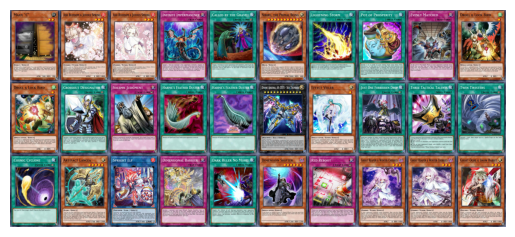

In [153]:
u = 10
v = 3
#######################################################
ind_hf = df.loc[(df['Staple'] == '범용'), 'Usage'].nlargest(u*v).index
db_code_freq = db_code[ind_hf]
db_digit_freq = db_digit[ind_hf]
db_name_freq = db_name_ko[ind_hf]
#######################################################
rgb_card_list_freq = []
for digit in db_digit_freq:
    dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
    img_card = cv2.imread(dir_card, cv2.IMREAD_COLOR)  # Load the image in color (RGB)
    rgb_card_list_freq.append(img_card)
#######################################################
# Create a 5x5 grid of the images
grid = np.vstack([np.hstack(rgb_card_list_freq[i:i+u]) for i in range(0, u*v, u)])
# Display the resulting image using pyplot
plt.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB))  # Convert the image to RGB format
plt.axis('off')
plt.show()

In [7]:
def filter_db(df, staple, usage, percent, extra, type, pen, deck):
    f_staple = True if staple is None else (df['Staple'] == staple)
    f_usage = True if usage is None else (df['Usage'] >= usage)
    f_percent = True if percent is None else (df['Percent'] >= percent)
    f_extra = True if extra is None else (df['Extra'] == extra)
    f_type = True if type is None else (df['Type'] == type)
    f_pen = True if pen is None else (df['Pendulum'] == pen)
    f_deck = True if deck is None else (df[f'U_{deck}'] > 0)
    db_filtered = df.loc[ f_staple & f_usage & f_percent & f_extra & f_type & f_pen & f_deck, 'Digit'].tolist()
    return db_filtered

In [8]:
usage_val = None
percent_val = 0.5
##############################################################################################################
db_digit_main = filter_db (df, staple=None, usage=usage_val, percent=None, extra='메인', type=None, pen=None, deck=None)
db_digit_extra = filter_db (df, staple=None, usage=usage_val, percent=None, extra='엑스트라', type=None, pen=None, deck=None)
##############################################################################################################
db_digit_normal = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='일반', pen=None, deck=None)
db_digit_effect = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='효과', pen=None, deck=None)
db_digit_ritual = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='의식', pen=None, deck=None)
##############################################################################################################
db_digit_fusion = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='융합', pen=None, deck=None)
db_digit_synchro = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='싱크로', pen=None, deck=None)
db_digit_xyz = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='엑시즈', pen=None, deck=None)
db_digit_link = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='링크', pen=None, deck=None)
db_digit_magic = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='마법', pen=None, deck=None)
db_digit_trap = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='함정', pen=None, deck=None)
##############################################################################################################
db_digit_pendulum = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type=None, pen=True, deck=None)
db_digit_pen_normal = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='일반', pen=True, deck=None)
db_digit_pen_effect = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='효과', pen=True, deck=None)
db_digit_pen_ritual = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='의식', pen=True, deck=None)
db_digit_pen_fusion = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='융합', pen=True, deck=None)
db_digit_pen_synchro = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='싱크로', pen=True, deck=None)
db_digit_pen_xyz = filter_db (df, staple=None, usage=usage_val, percent=None, extra=None, type='엑시즈', pen=True, deck=None)
##############################################################################################################
db_digit_side_magic = filter_db (df, staple=None, usage=usage_val, percent=percent_val, extra=None, type='마법', pen=None, deck='Side')
db_digit_side_trap = filter_db (df, staple=None, usage=usage_val, percent=percent_val, extra=None, type='함정', pen=None, deck='Side')

# 00 Preview Data

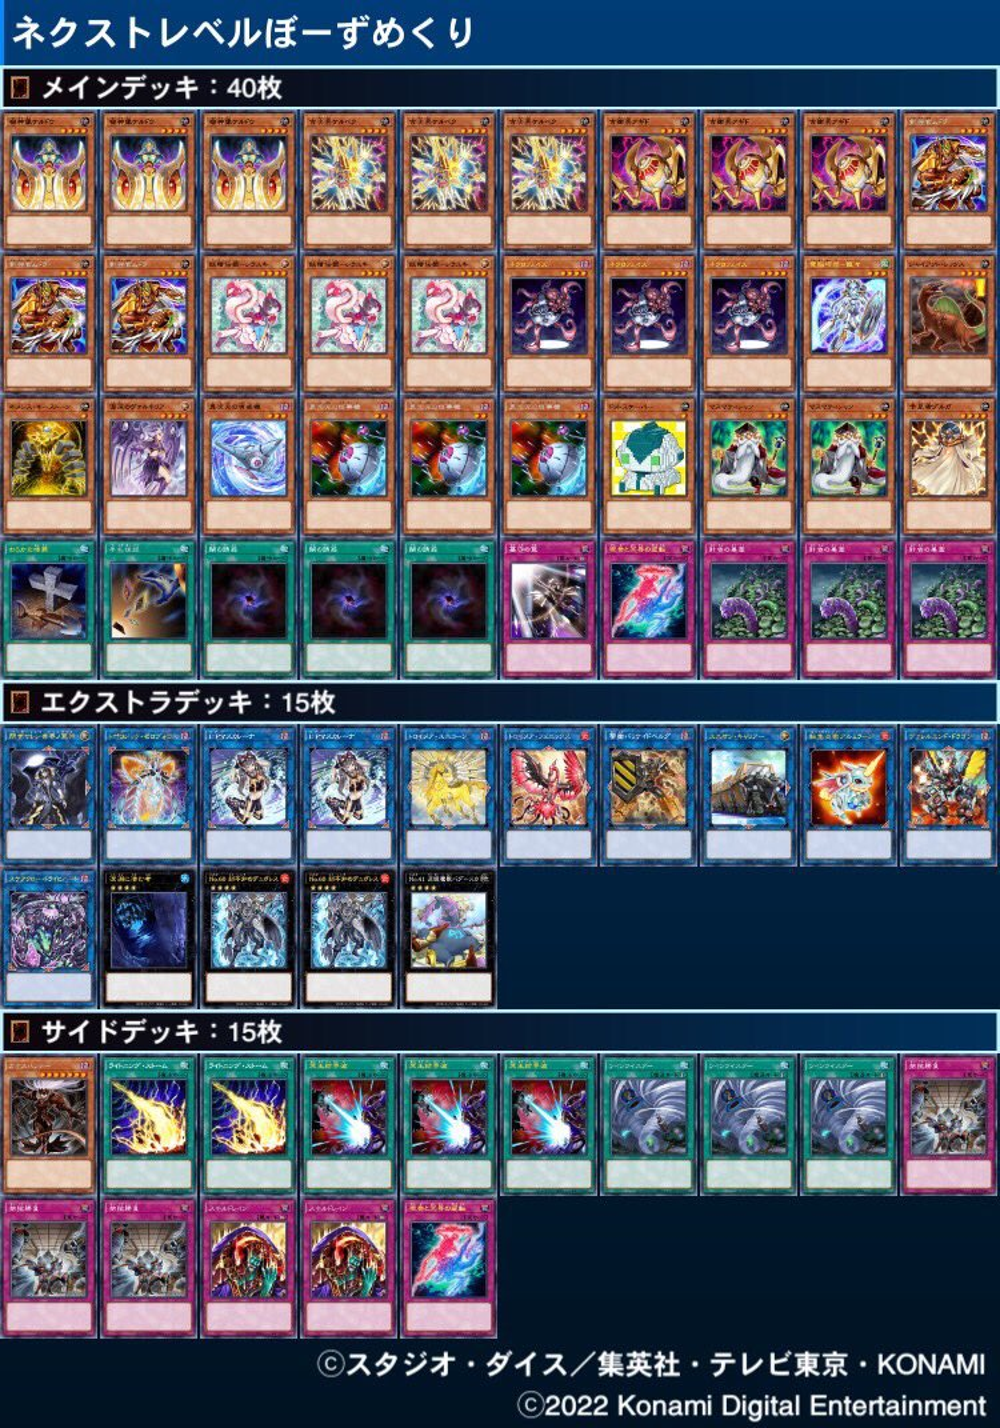

In [514]:
# Find deck path by deck_code
deck_code = '0872-004' 
dir_deck = search_deck(deck_code)
#######################################################
image = Image.open(dir_deck)
o_size = image.size
f = 1000
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

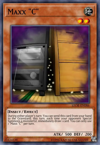

In [10]:
local = 'ko'
card_name = "증식의 G"
digit = search_digit(card_name, local)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
image=Image.open(dir_card)
o_size = image.size
f = 100
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

# 01 Guess Single Card

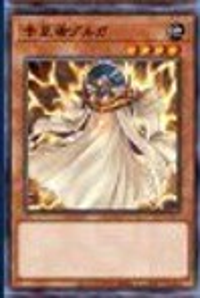

In [518]:
dir_snap_shot = f'{dir_main}/Data/snap_24.jpg'
image=Image.open(dir_snap_shot)
o_size = image.size
f = 200
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

0872-004 | -Found cache for 036              |
0872-004 | -Loading cache for 036            |
0872-004 | -Loaded cache for 036             | 0.07
____________________________________________________________
성역의 노랫소리 | 마제스펙터 템피스트 | 빛의 결계 | 일제봉기 | 극염무－「성두」 | 궁극 배수의 진 | 엑시즈 베일 | 사막의 빛 | 사이코 쇼크웨이브 | 피켈의 독심술
유리구두 | 세인트 디클레어러 | 바렐 리프리저레이션 | 금지된 성배 | 예견자 졸가 | 사이퍼 윙 | 버밀리온 디클레어러 | 몽마경의 꿈대화 | 진화의 분기점 | 각성의 빛
성각신룡－에네아드 | 진염의 폭발 | 싱크로 존 | 와타폰 | 포톤 베일 | No.11 빅 아이 | 섬광의 베리어 －샤이닝 포스－ | 마도서 정리 | 사이코 리액터 | 금빛의 날치
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
|                      성역의 노랫소리                      |


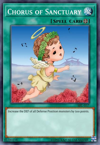

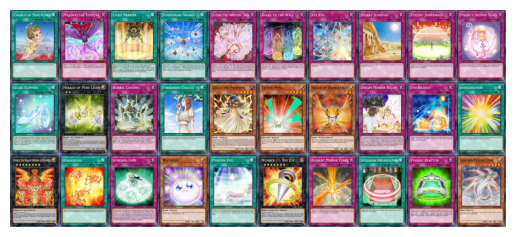

In [519]:
local = 'ko'
snap_shot_width = 40
card_width = math.floor(snap_shot_width * 0.9)
#####################################################################
threshold = 0.5
#####################################################################
dup_tol = math.ceil(card_width/1.95)
sort_round = math.ceil(card_width/1.95)
digit_list = db_digit_max # Specify 
# digit_list = db_digit_effect
#####################################################################
img_snap = cv2.imread(dir_snap_shot)
img_snap = imutils.resize(img_snap, width = snap_shot_width)
img_snap = cv2.cvtColor(img_snap, cv2.COLOR_BGR2GRAY)
#####################################################################
perf_round = 2
#####################################################################
# Check Cache
cache_files = list(dir_main.glob('Output/cache_*.npy'))
cache_names = [Path(file).stem for file in cache_files]
#####################################################################
if f'cache_{card_width:03d}' in cache_names:
    print(f'{deck_code} | -Found cache for {card_width:03d}              |')
else:
    print(f'{deck_code} | -No cache for {card_width:03d}                 |')
    # getting info
    dir_cache_max = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in db_digit_max]
    # resizing
    tcs = time.perf_counter()
    print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
    load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_cache_max]
    dict_card_list = dict(zip(db_digit_max, load_card_list))
    # saving cache
    dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
    np.save(dir_cache_card_save, dict_card_list)
    print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
#####################################################################
# loading cache
tcl = time.perf_counter()
print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
#####################################################################
card_loc = []
card_pos = []
for img_card in filter_card_list:
    res = cv2.matchTemplate(img_snap, img_card, cv2.TM_CCOEFF_NORMED)
    loc=np.where(res >= threshold)
    num_loc = tuple(zip(*loc[::-1]))
    num_pos = res[loc]
    card_loc.append(num_loc)
    card_pos.append(num_pos)
#####################################################################
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
#######################################################
zip_list = list(zip(zip_digit, zip_pos))
sorted_zip_list = sorted(zip_list, key=lambda x: x[1], reverse=True)
sorted_digit = [zip[0] for zip in sorted_zip_list]
set_digit = unique_in_order(sorted_digit)
#######################################################
u = 10
v = 3
#######################################################
names = trans_name(set_digit, local)
names = names[:u*v]
#######################################################
items_per_line = u
separator = ' | '
print('_'*60)
# Iterate over the items and print them in groups
for i in range(0, len(names), items_per_line):
    print(separator.join(  names[i:i+items_per_line]  ))
print('‾'*60)
print(f'| {names[0]:^50} |')
#######################################################
card_name = names[0]
digit = search_digit(card_name, local)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
image=Image.open(dir_card)
o_size = image.size
f = 100
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)
#######################################################
digits = set_digit[:u*v]
img_plot_rgb = []
for digit in digits:
    dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
    img_card = cv2.imread(dir_card, cv2.IMREAD_COLOR)  # Load the image in color (RGB)
    img_plot_rgb.append(img_card)
#######################################################
# Create a 5x5 grid of the images
grid = np.vstack([np.hstack(img_plot_rgb[i:i+u]) for i in range(0, u*v, u)])
# Display the resulting image using pyplot
plt.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB))  # Convert the image to RGB format
plt.axis('off')
plt.show()

# 2 Using Simple Card Pool

### 2-1 Parameters

1354-003 | Width of Deck         | 400
1354-003 | Width of Card         | 39
-- [39, 39, 39, 39, 39] --
1354-003 | Matchng Threshold     | 0.9
1354-003 | Duplicate Tolearance  | 20
1354-003 | Sorting Round         | 20
1354-003 | Cards to match        | 30


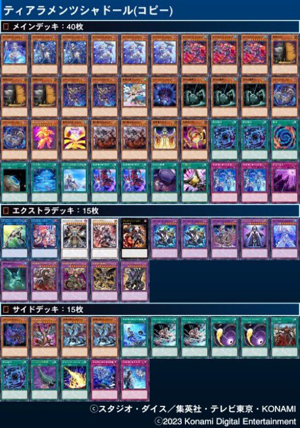

In [154]:
# Parameters
local = 'ko'
#######################################################
# Find deck path by deck_code
deck_code = '1354-003' # check for image named deck_code under Deck folder
dir_deck = search_deck(deck_code)
#######################################################
deck_width = 400
print(f'{deck_code} | Width of Deck         | {deck_width}')
#######################################################
img_deck = cv2.imread(dir_deck)
img_deck = imutils.resize(img_deck, width = deck_width)
img_deck = cv2.cvtColor(img_deck, cv2.COLOR_BGR2GRAY)
#######################################################
exp_card_width = deck_width/10
card_min = int(exp_card_width *0.8) 
card_max = int(exp_card_width *1.1)
step = card_max-card_min+1
#######################################################
threshold = 0.9
card_width_list = []
for digit in db_digit_freq:
    ind = np.where(db_digit == int(digit))[0][0]
    pen = db_pen[ind]
    dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
    img_card = cv2.imread(dir_card, 0)
    if pen:
        card_widht = None
    else:
        card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
    if card_width != None:
        card_width_list.append(card_width)
#######################################################
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
    print(f'{deck_code} | Width of Card         | {card_width}')
except ZeroDivisionError:
    card_width = round_near(exp_card_width)
    print(f"{deck_code} | Width of Card; Zero Div Error | {card_width}")
print(f'-- {card_width_list} --' )
#######################################################
dup_tol = math.ceil(card_width/1.95)
sort_round = math.ceil(card_width/1.95)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
digit_list = db_digit_freq
print(f'{deck_code} | Cards to match        | {len(digit_list)}')
#######################################################
image = Image.open(dir_deck)
o_size = image.size
f = 300
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

### 2-2 Solver 

In [155]:
# Load images and resize for card_width 
img_card_list = []
for digit in digit_list:
    dir_card = f"{dir_main}/YGO_DB/{digit}.jpg"
    img_card = cv2.imread(dir_card, 0)
    img_card = imutils.resize(img_card, width = card_width)
    img_card_list.append(img_card)
#####################################################################
args = [
    [img_card, img_deck, threshold]
    for img_card in img_card_list
]
#####################################################################
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
#####################################################################
card_loc = [item[0] for item in result]
card_pos = [item[1] for item in result]
#####################################################################
# Translator
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
dup_pt, dup_ind = trans_dup (zip_pt, dup_tol)
group_pt, group_pos, group_digit = trans_group (dup_ind, zip_pt, zip_pos, zip_digit)
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
sort_name = trans_name(sort_digit, local)
sort_extra = trans_extra(sort_digit)
deck_list = trans_paste(sort_name, sort_extra, deck_code)
print(sort_name)
#####################################################################

['증식의 G', '증식의 G', '증식의 G', '삼전의 재', '코즈믹 싸이크론', '코즈믹 싸이크론', '해피의 깃털', '라이트닝 스톰']


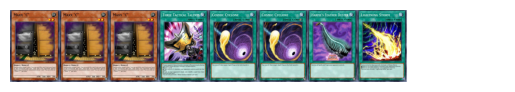

In [156]:
u = 10

digit_main, digit_extra, digit_side = split_deck(sort_digit,sort_extra)

try:
    img_deck_main = trans_deck(digit_main, u)
except:
    img_deck_main = []
try:
    img_deck_extra = trans_deck(digit_extra, u)
except:
    img_deck_extra = []
try:
    img_deck_side = trans_deck(digit_side, u)
except:
    img_deck_side = []

img_deck_all = img_deck_main + img_deck_extra + img_deck_side

v = int(len(img_deck_all) / u)

grid = np.vstack([np.hstack(img_deck_all[i:i+u]) for i in range(0, u*v, u)])
plt.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB))  # Convert the image to RGB format
plt.axis('off')
plt.show()

# 3 Using IMG

### 3-1 Parameters

0313-001 | Width of Deck         | 400
0313-001 | Width of Card         | 38
-- [38, 38, 38, 38, 38, 38, 38, 39, 37, 38, 38, 38, 38, 38] --
0313-001 | Matchng Threshold     | 0.75
0313-001 | Duplicate Tolearance  | 19
0313-001 | Sorting Round         | 19
0313-001 | Cards to match        | 7436


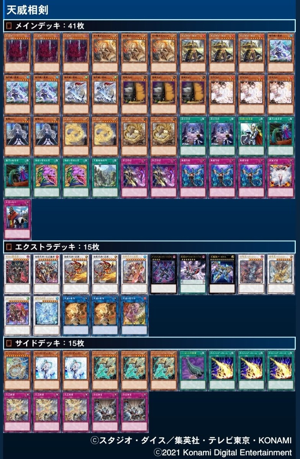

In [451]:
# Parameters
local = 'ko'
#######################################################
# Find deck path by deck_code
deck_code = '0313-001' 
dir_deck = search_deck(deck_code)
#######################################################
deck_width = 400
print(f'{deck_code} | Width of Deck         | {deck_width}')
#######################################################
img_deck = cv2.imread(dir_deck)
img_deck = imutils.resize(img_deck, width = deck_width)
img_deck = cv2.cvtColor(img_deck, cv2.COLOR_BGR2GRAY)
#######################################################
exp_card_width = deck_width/10 # change the number according to abnormal sized decks
card_min = int(exp_card_width *0.8) 
card_max = int(exp_card_width *1.1)
step = card_max-card_min+1
#######################################################
threshold = 0.75 #lower the values to include more results / increase in false positive as a drawback
card_width_list = []
for digit in db_digit_freq:
    ind = np.where(db_digit == int(digit))[0][0]
    pen = db_pen[ind]
    dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
    img_card = cv2.imread(dir_card, 0)
    if pen:
        card_widht = None
    else:
        card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
    if card_width != None:
        card_width_list.append(card_width)
#######################################################
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
    print(f'{deck_code} | Width of Card         | {card_width}')
except ZeroDivisionError:
    card_width = round_near(exp_card_width)
    print(f"{deck_code} | Width of Card; Zero Div Error | {card_width}")
print(f'-- {card_width_list} --' )
#######################################################
dup_tol = math.floor(card_width / 2)
sort_round = math.floor(card_width / 2)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
digit_list = db_digit_avr
print(f'{deck_code} | Cards to match        | {len(digit_list)}')
#######################################################
image = Image.open(dir_deck)
o_size = image.size
f = 300
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

### 3-2 Solver

In [158]:
# Solver
perf_round = 2
print(f'{deck_code} | Started Process                   | Run')
t1 = time.perf_counter()
#####################################################################
# Load images and resize for card_width 
print(f'{deck_code} | -Converting Image for {card_width:03d}         |')
img_card_list = []
for digit in digit_list:
    dir_card = f"{dir_main}/YGO_DB/{digit}.jpg"
    img_card = cv2.imread(dir_card, 0)
    img_card = imutils.resize(img_card, width = card_width)
    img_card_list.append(img_card)
print(f'{deck_code} | -Converted Image for {card_width:03d}          | { round(time.perf_counter() - t1 , perf_round)}')
#####################################################################
args = [
    [img_card, img_deck, threshold]
    for img_card in img_card_list
]
#####################################################################
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - t1 , perf_round)}")
#####################################################################
t2 = time.perf_counter()
card_loc = [item[0] for item in result]
card_pos = [item[1] for item in result]
#####################################################################
# Translator
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
dup_pt, dup_ind = trans_dup (zip_pt, dup_tol)
group_pt, group_pos, group_digit = trans_group (dup_ind, zip_pt, zip_pos, zip_digit)
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
sort_name = trans_name(sort_digit, local)
sort_extra = trans_extra(sort_digit)
deck_list = trans_paste(sort_name, sort_extra, deck_code)
print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
dir_write = f'{dir_main}/Output/single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)
print(f"{deck_code} | Finished Process in               | = { round(time.perf_counter() - t1 , perf_round)}")

0313-001 | Started Process                   | Run
0313-001 | -Converting Image for 038         |
0313-001 | -Converted Image for 038          | 17.17
0313-001 | -Finished Template Matching in    | 26.2
0313-001 | -Finished Translating in          | 0.15
0313-001 | Finished Process in               | = 26.52


### Plotter

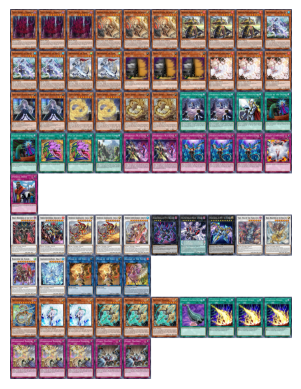

In [159]:
u = 10

digit_main, digit_extra, digit_side = split_deck(sort_digit,sort_extra)
img_deck_main = trans_deck(digit_main, u)
img_deck_extra = trans_deck(digit_extra, u)
img_deck_side = trans_deck(digit_side, u)
img_deck_all = img_deck_main + img_deck_extra + img_deck_side

v = int(len(img_deck_all) / u)

grid = np.vstack([np.hstack(img_deck_all[i:i+u]) for i in range(0, u*v, u)])
plt.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB))  # Convert the image to RGB format
plt.axis('off')
plt.show()

### Exporter

In [52]:
# Export Data
package = [deck_code]
for i, digit in enumerate(digit_list):
    # digit = digit_list[i]
    for j in range(len(card_loc[i])):
        coord = card_loc[i][j]
        coX = coord[0]
        coY = coord[1]
        pos = card_pos[i][j]
        ind = np.where(db_digit == int(digit))[0][0]
        name = np.asarray(df[f"Name_{local.upper()}"])[ind]
        package.append(f'{coX}, {coY}, {digit}, {pos}, {name}')

dir_write = f'{dir_main}\Output\package.txt'
with open(dir_write, 'w', encoding="utf-8") as fp:
    for item in package:
        fp.write("%s\n" % item)

# 4 Using Cache

### 4-1 Parameters

0022-002 | Width of Deck         | 400
0022-002 | Width of Card         | 39
-- [40, 40, 37, 40, 40, 39, 39, 40, 39, 38, 40, 40, 39, 39, 39, 39] --
0022-002 | Matchng Threshold     | 0.75
0022-002 | Duplicate Tolearance  | 19
0022-002 | Sorting Round         | 19
0022-002 | Cards to match        | 2751


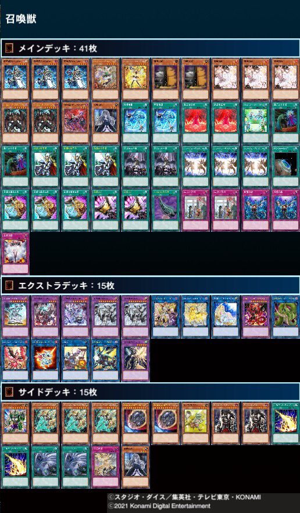

In [480]:
# Parameters
local = 'ko'
#######################################################
# Find deck path by deck_code
deck_code = '0022-002'
dir_deck = search_deck(deck_code)
#######################################################
deck_width = 400
print(f'{deck_code} | Width of Deck         | {deck_width}')
#######################################################
img_deck = cv2.imread(dir_deck)
img_deck = imutils.resize(img_deck, width = deck_width)
img_deck = cv2.cvtColor(img_deck, cv2.COLOR_BGR2GRAY)
#######################################################
exp_card_width = deck_width/10 # change the number according to abnormal sized decks
card_min = int(exp_card_width *0.8) 
card_max = int(exp_card_width *1.1)
step = card_max-card_min+1
#######################################################
threshold = 0.75
card_width_list = []
for digit in db_digit_freq:
    ind = np.where(db_digit == int(digit))[0][0]
    pen = db_pen[ind]
    dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
    img_card = cv2.imread(dir_card, 0)
    if pen:
        card_widht = None
    else:
        card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
    if card_width != None:
        card_width_list.append(card_width)
#######################################################
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
    print(f'{deck_code} | Width of Card         | {card_width}')
except ZeroDivisionError:
    card_width = round_near(exp_card_width)
    print(f"{deck_code} | Width of Card; Zero Div Error | {card_width}")
print(f'-- {card_width_list} --' )
#######################################################
dup_tol = math.floor(card_width / 2)
sort_round = math.floor(card_width / 2)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
digit_list = db_digit_min
print(f'{deck_code} | Cards to match        | {len(digit_list)}')
#######################################################
image = Image.open(dir_deck)
o_size = image.size
f = 300
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

### 4-2 Solver

In [473]:
## Solution
print(f'{deck_code} | Started Process                   | Run')
perf_round = 2
t1 = time.perf_counter()
#####################################################################
# Check Cache
cache_files = list(dir_main.glob('Output/cache_*.npy'))
cache_names = [Path(file).stem for file in cache_files]
#####################################################################
if f'cache_{card_width:03d}' in cache_names:
    print(f'{deck_code} | -Found cache for {card_width:03d}              |')
else:
    print(f'{deck_code} | -No cache for {card_width:03d}                 |')
    # getting info
    dir_cache_max = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in db_digit_max]
    # resizing
    tcs = time.perf_counter()
    print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
    load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_cache_max]
    dict_card_list = dict(zip(db_digit_max, load_card_list))
    # saving cache
    dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
    np.save(dir_cache_card_save, dict_card_list)
    print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
#####################################################################
# loading cache
tcl = time.perf_counter()
print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
#####################################################################
# Variables
tm = time.perf_counter()
args = [[img_card, img_deck, threshold] for img_card in filter_card_list]
#####################################################################
# Solver
print(f'{deck_code} | -Starting Templating Matching     | { round(time.perf_counter() - tm , perf_round)}')
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
#####################################################################
print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - tm , perf_round)}")
t2 = time.perf_counter()
#####################################################################
card_loc = [item[0] for item in result]
card_pos = [item[1] for item in result]
#####################################################################
# Translator
tt = time.perf_counter()
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
print(f"{deck_code} |     Converting 1 : Raw            | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
dup_pt, dup_ind = trans_dup (zip_pt, dup_tol)
print(f"{deck_code} |     Converting 2 : Dup            | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
group_pt, group_pos, group_digit = trans_group (dup_ind, zip_pt, zip_pos, zip_digit)
print(f"{deck_code} |     Converting 3 : Group          | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
print(f"{deck_code} |     Converting 4 : Sort           | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
sort_name = trans_name(sort_digit, local)
print(f"{deck_code} |     Converting 5 : Name           | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
sort_extra = trans_extra(sort_digit)
print(f"{deck_code} |     Converting 6 : Type           | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
deck_list = trans_paste(sort_name, sort_extra, deck_code)
print(f"{deck_code} |     Converting 7 : Paste          | { round(time.perf_counter() - tt , perf_round)}")
#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
#####################################################################
print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
print(f"{deck_code} | Finished Process in               | = { round(time.perf_counter() - t1 , perf_round)}")
#####################################################################
dir_write = f'{dir_main}\Output\single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)

0020-003 | Started Process                   | Run
0020-003 | -Found cache for 039              |
0020-003 | -Loading cache for 039            |
0020-003 | -Loaded cache for 039             | 0.06
0020-003 | -Starting Templating Matching     | 0.0
0020-003 | -Finished Template Matching in    | 3.9
0020-003 |     Converting 1 : Raw            | 0.0
0020-003 |     Converting 2 : Dup            | 0.03
0020-003 |     Converting 3 : Group          | 0.0
0020-003 |     Converting 4 : Sort           | 0.0
0020-003 |     Converting 5 : Name           | 0.0
0020-003 |     Converting 6 : Type           | 0.0
0020-003 |     Converting 7 : Paste          | 0.0
0020-003 | -Finished Translating in          | 0.04
0020-003 | Finished Process in               | = 4.0


### Plotter

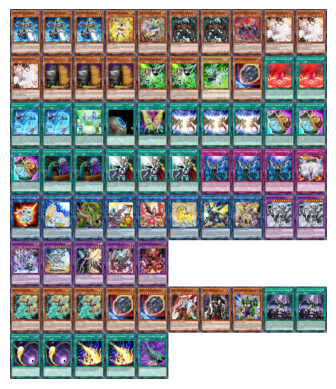

In [454]:
u = 10

digit_main, digit_extra, digit_side = split_deck(sort_digit,sort_extra)
img_deck_main = trans_deck(digit_main, u)
img_deck_extra = trans_deck(digit_extra, u)
img_deck_side = trans_deck(digit_side, u)
img_deck_all = img_deck_main + img_deck_extra + img_deck_side

v = int(len(img_deck_all) / u)

grid = np.vstack([np.hstack(img_deck_all[i:i+u]) for i in range(0, u*v, u)])
plt.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB))  # Convert the image to RGB format
plt.axis('off')
plt.show()

### Exporter

In [ ]:
# Export Data
package = [deck_code]
for i, digit in enumerate(digit_list):
    # digit = digit_list[i]
    for j in range(len(card_loc[i])):
        coord = card_loc[i][j]
        coX = coord[0]
        coY = coord[1]
        pos = card_pos[i][j]
        ind = np.where(db_digit == int(digit))[0][0]
        name = np.asarray(df[f"Name_{local.upper()}"])[ind]
        package.append(f'{coX}, {coY}, {digit}, {pos}, {name}')

dir_write = f'{dir_main}\Output\package.txt'
with open(dir_write, 'w', encoding="utf-8") as fp:
    for item in package:
        fp.write("%s\n" % item)

## 5 Multiple Decks

### 5-1 Parameters

In [481]:
# Parameters
local = 'ko'
deck_code = '0000-000'
deck_width = 400
print(f'{deck_code} | Width of Deck         | {deck_width}')
#######################################################
exp_card_width = deck_width/10 # change the number according to abnormal sized decks
card_min = int(exp_card_width *0.8) 
card_max = int(exp_card_width *1.1)
step = card_max-card_min+1
#######################################################
threshold = 0.75
#######################################################
dup_tol = math.floor(card_width / 2)
sort_round = math.floor(card_width / 2)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
digit_list = db_digit_min
print(f'{deck_code} | Cards to match        | {len(digit_list)}')
#######################################################
dir_deck_db = f'{dir_main}/Data/deck_db.txt'
deck_code_list = np.loadtxt(dir_deck_db, dtype='str')
print(f'{deck_code} | Decks to match        | {len(deck_code_list)}')
#######################################################

0000-000 | Width of Deck         | 400
0000-000 | Matchng Threshold     | 0.75
0000-000 | Duplicate Tolearance  | 19
0000-000 | Sorting Round         | 19
0000-000 | Cards to match        | 2751
0000-000 | Decks to match        | 132


### 5-2 Solver

In [483]:
it_a, it_b = 1, 132
#######################################################
perf_round = 2
t0 = time.perf_counter()
initial_width = None
master_db = []
for i in range(it_a,it_b):
    #####################################################################
    deck_code = deck_code_list[i]
    dir_deck = f"{dir_main}/Deck/{deck_code}.jpg"
    #####################################################################
    print('======================================================')
    print(f'{deck_code} |          Started Process          | Run {i}/{it_b}')
    t1 = time.perf_counter()
    #####################################################################
    img_deck = cv2.cvtColor(imutils.resize(cv2.imread(dir_deck), width=deck_width), cv2.COLOR_BGR2GRAY)
    card_width_list = []
    for digit in db_digit_freq:
        ind = np.where(db_digit == int(digit))[0][0]
        pen = db_pen[ind]
        dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
        img_card = cv2.imread(dir_card, 0)
        if pen:
            card_widht = None
        else:
            card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
        if card_width != None:
            card_width_list.append(card_width)
    #######################################################
    print(f'{deck_code} | -Width of Deck                    | {deck_width}')
    try:
        card_width = round_near(sum(card_width_list) / len(card_width_list))
        pass_token = True
        print(f'{deck_code} | -Width of Card                    | {card_width}')
    except ZeroDivisionError:
        card_width = round_near(exp_card_width)
        pass_token = False
        print(f'{"Zero Division Error":^50}')
        print(f'{deck_code} | -Width of Card                    | {card_width}')
    #######################################################
    dup_tol = math.floor(card_width / 2)
    sort_round = math.floor(card_width / 2)
    #####################################################################
    cache_files = list(dir_main.glob('Output/cache_*.npy'))
    cache_names = [Path(file).stem for file in cache_files]
    #####################################################################
    # checking cache
    if f'cache_{card_width:03d}' in cache_names:
        print(f'{deck_code} | -Found cache for {card_width:03d}              |')
    else:
        print(f'{deck_code} | -No cache for {card_width:03d}                 |')
        # getting info
        dir_cache_max = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in db_digit_max]
        #####################################################################
        tcs = time.perf_counter()
        print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
        #####################################################################
        # resizing
        load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_cache_max]
        dict_card_list = dict(zip(db_digit_max , load_card_list))
        # saving cache
        dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
        np.save(dir_cache_card_save, dict_card_list)
        print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
    #####################################################################
    # loading cache
    tcl = time.perf_counter()
    print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
    # save time when loading same results to previous run
    if initial_width and initial_width == card_width:
        filter_card_list = filter_card_list
        print(f'{"Using Previous Cache":^50}')
    else:
        dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
        cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
        filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
    initial_width = card_width
    print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
    #####################################################################
    # Variables
    tm = time.perf_counter()
    args = [[img_card, img_deck, threshold] for img_card in filter_card_list]
    #####################################################################
    # Solver
    print(f'{deck_code} | -Starting Templating Matching     | { round(time.perf_counter() - tm , perf_round)}')
    if pass_token:
        with Pool(n_cpu-1) as pool:
            result = pool.starmap(match_card, args)
        pool.close()
    else:
        print(f'{"Passing Template Matching":^50}')
    #####################################################################
    print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - tm , perf_round)}")
    t2 = time.perf_counter()
    #####################################################################
    if pass_token:
        card_loc = [item[0] for item in result]
        card_pos = [item[1] for item in result]
        #####################################################################
        tt = time.perf_counter()
        zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
        print(f"{deck_code} |     Converting 1 : Raw            | { round(time.perf_counter() - tt , perf_round)}")

        tt = time.perf_counter()
        dup_pt, dup_ind = trans_dup (zip_pt, dup_tol)
        print(f"{deck_code} |     Converting 2 : Dup            | { round(time.perf_counter() - tt , perf_round)}")

        tt = time.perf_counter()
        group_pt, group_pos, group_digit = trans_group (dup_ind, zip_pt, zip_pos, zip_digit)
        print(f"{deck_code} |     Converting 3 : Group          | { round(time.perf_counter() - tt , perf_round)}")

        tt = time.perf_counter()
        sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
        print(f"{deck_code} |     Converting 4 : Sort           | { round(time.perf_counter() - tt , perf_round)}")

        tt = time.perf_counter()
        sort_name = trans_name(sort_digit, local)
        print(f"{deck_code} |     Converting 5 : Name           | { round(time.perf_counter() - tt , perf_round)}")

        tt = time.perf_counter()
        sort_extra = trans_extra(sort_digit)
        print(f"{deck_code} |     Converting 6 : Type           | { round(time.perf_counter() - tt , perf_round)}")
        
        tt = time.perf_counter()
        deck_list = trans_paste(sort_name, sort_extra, deck_code)
        print(f"{deck_code} |     Converting 7 : Paste          | { round(time.perf_counter() - tt , perf_round)}")
    else: # If no card with is found
        deck_list = [deck_code, 'Error, No Card Found']
    #####################################################################
    master_db.append("\t".join(str(x) for x in deck_list))
    #####################################################################
    print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
    print(f"{deck_code} |        Finished Process in        | = { round(time.perf_counter() - t1 , perf_round)}")
    #####################################################################
dir_write = f'{dir_main}\Output\mp_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)
print(f'         |         Gross Computation         | = { round(time.perf_counter() - t0 , perf_round)}')

0025-001 |          Started Process          | Run 1/132
0025-001 | -Width of Deck                    | 400
0025-001 | -Width of Card                    | 39
0025-001 | -Found cache for 039              |
0025-001 | -Loading cache for 039            |
0025-001 | -Loaded cache for 039             | 0.06
0025-001 | -Starting Templating Matching     | 0.0
0025-001 | -Finished Template Matching in    | 4.8
0025-001 |     Converting 1 : Raw            | 0.0
0025-001 |     Converting 2 : Dup            | 0.05
0025-001 |     Converting 3 : Group          | 0.0
0025-001 |     Converting 4 : Sort           | 0.01
0025-001 |     Converting 5 : Name           | 0.0
0025-001 |     Converting 6 : Type           | 0.0
0025-001 |     Converting 7 : Paste          | 0.0
0025-001 | -Finished Translating in          | 0.06
0025-001 |        Finished Process in        | = 6.56
0037-002 |          Started Process          | Run 2/132
0037-002 | -Width of Deck                    | 400
0037-002 | -Width of 

### Test Card Widths for list of decks

In [ ]:
average_list = []
for deck_code in deck_code_list[:10]:
    dir_deck = f"{dir_main}/Deck/{deck_code}.jpg"
    deck_code = Path(dir_deck).stem
    card_width_list = []

    for digit in db_digit_freq:
        dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
        img_card = cv2.imread(dir_card, 0)
        card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
        if card_width != None:
            card_width_list.append(card_width)

    try:
        average = round_near(sum(card_width_list) / len(card_width_list))
        average_list.append(average)
        print(f'{deck_code} | average card width is : {average}')
    except ZeroDivisionError:
        print(f'{deck_code} | Zero Division Error')

list_average = round_near(sum(average_list) / len(average_list))
print(f'-- average card width overall {list_average} --')

# 00 Part of blured card

In [ ]:
dir_blur = f'{dir_main}/Data/blur_01.jpg'
#######################################################
img_view = cv2.imread(dir_blur)
plt.imshow(cv2.cvtColor(img_view, cv2.COLOR_BGR2RGB))  # Convert the image to RGB format
# plt.axis('off')
plt.show()

In [ ]:
local = 'ko'
card_name = "스프라이트 블루"
digit = search_digit(card_name, local)
dir_card = f'{dir_main}/YGO_DB_Crop/{digit}.jpg'
#######################################################
img_view = cv2.imread(dir_card)
plt.imshow(cv2.cvtColor(img_view, cv2.COLOR_BGR2RGB))  # Convert the image to RGB format
# plt.axis('off')
plt.show()

In [ ]:
original_width = 100 # resizing to source original size 100
img_rgb = cv2.imread(dir_card)
img_rgb = imutils.resize(img_rgb, width = original_width)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

dir_write_gray = f'{dir_main}/Output/blur_gray.jpg'
cv2.imwrite(dir_write_gray, img_gray)
img_gray = cv2.imread(dir_write_gray)

# crop region
dX = 20
dY = 40
pX = 0
pY = 0
top_left = (pX,pY)
bottom_right = (pX + dX, pY+ dY)

dir_write_rec = f'{dir_main}/Output/blur_rec.jpg'
cv2.rectangle(img_gray, top_left, bottom_right, (0,0,255), 1)
cv2.imwrite(dir_write_rec, img_gray)

dir_write_crop = f'{dir_main}/Output/blur_crop.jpg'
img_crop = img_rgb[pY:pY+dY,pX:pX+dX]
cv2.imwrite(dir_write_crop, img_crop)

In [ ]:
dir_file = dir_write_rec
#######################################################
img_view = cv2.imread(dir_file)
plt.imshow(cv2.cvtColor(img_view, cv2.COLOR_BGR2RGB))  # Convert the image to RGB format
# plt.axis('off')
plt.show()

In [ ]:
dir_file = dir_write_crop
#######################################################
img_view = cv2.imread(dir_file)
plt.imshow(cv2.cvtColor(img_view, cv2.COLOR_BGR2RGB))  # Convert the image to RGB format
# plt.axis('off')
plt.show()

### Process Images

In [ ]:
db_digit_effect = filter_db (df, staple=None, usage=1, percent=None, extra=None, type='효과', pen=None, deck=None)
digit_list = db_digit_max
#####################################################################
print(f'0000-000 | Cards to match        | {len(digit_list)}')
#####################################################################

In [ ]:
perf_round = 2
local = 'ko'
#####################################################################
img_blur = cv2.imread(dir_blur,0)
#####################################################################
snap_shot_width = img_blur.shape[-1]
card_width = math.floor(snap_shot_width *0.9)
threshold = 0.6
#####################################################################
dup_tol = math.ceil(card_width/1.95)
sort_round = math.ceil(card_width/1.95)
#####################################################################

### Test for candidate

In [ ]:
card_name = "스프라이트 블루"
digit = search_digit(card_name, local)
dir_card = f'{dir_main}/YGO_DB_Crop/{digit}.jpg'
img_card = cv2.imread(dir_card, 0)
img_card = imutils.resize(img_card, width = original_width)
img_card = img_card[pY:pY+dY,pX:pX+dX]
img_card = imutils.resize(img_card, width = card_width) # scale smaller

In [ ]:
card_loc = []
card_pos = []

res = cv2.matchTemplate(img_blur, img_card, cv2.TM_CCOEFF_NORMED)
loc=np.where(res >= threshold)
num_loc = tuple(zip(*loc[::-1]))
num_pos = res[loc]

card_loc.append(num_loc)
card_pos.append(num_pos)

In [ ]:
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos, [digit])
#######################################################
zip_list = list(zip(zip_digit, zip_pos))
sorted_zip_list = sorted(zip_list, key=lambda x: x[1], reverse=True)
sorted_digit = [zip[0] for zip in sorted_zip_list]
set_digit = unique_in_order(sorted_digit)

In [ ]:
#######################################################
names = trans_name(set_digit, local)
print(len(names))
names = names[:u*v]
#######################################################
items_per_line = u
separator = ' | '
print('_'*60)
# Iterate over the items and print them in groups
for i in range(0, len(names), items_per_line):
    print(separator.join(  names[i:i+items_per_line]  ))
print('‾'*60)
print(f'| {names[0]:^50} |')
#######################################################
card_name = names[0]
digit = search_digit(card_name, local)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
image=Image.open(dir_card)
o_size = image.size
f = 100
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)
#######################################################

In [ ]:
img_crop_list = []
for digit in digit_list:
    dir_card = f'{dir_main}/YGO_DB_Crop/{digit}.jpg'
    img_card = cv2.imread(dir_card, 0)
    img_card = imutils.resize(img_card, width = snap_shot_width)
    img_card = img_card[pY:pY+dY,pX:pX+dX]
    img_card = imutils.resize(img_card, width = card_width)
    img_crop_list.append(img_card)

In [ ]:
card_loc = []
card_pos = []
for img_card in img_crop_list:
    res = cv2.matchTemplate(img_blur, img_card, cv2.TM_CCOEFF_NORMED)
    loc=np.where(res >= threshold)
    num_loc = tuple(zip(*loc[::-1]))
    num_pos = res[loc]
    card_loc.append(num_loc)
    card_pos.append(num_pos)

In [ ]:
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)

In [ ]:
#######################################################
zip_list = list(zip(zip_digit, zip_pos))
sorted_zip_list = sorted(zip_list, key=lambda x: x[1], reverse=True)
sorted_digit = [zip[0] for zip in sorted_zip_list]
set_digit = unique_in_order(sorted_digit)

In [ ]:
#######################################################
names = trans_name(set_digit, local)
print(len(names))

u = len(names)
v = 1

names = names[:u*v]
#######################################################
items_per_line = u
separator = ' | '
print('_'*60)
# Iterate over the items and print them in groups
for i in range(0, len(names), items_per_line):
    print(separator.join(  names[i:i+items_per_line]  ))
print('‾'*60)
print(f'| {names[0]:^50} |')
#######################################################
card_name = names[0]
digit = search_digit(card_name, local)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
image=Image.open(dir_card)
o_size = image.size
f = 100
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)
#######################################################
digits = set_digit[:u*v]
img_plot_rgb = []
for digit in digits:
    dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
    img_card = cv2.imread(dir_card, cv2.IMREAD_COLOR)  # Load the image in color (RGB)
    img_plot_rgb.append(img_card)
#######################################################
# Create a 5x5 grid of the images
grid = np.vstack([np.hstack(img_plot_rgb[i:i+u]) for i in range(0, u*v, u)])
# Display the resulting image using pyplot
plt.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB))  # Convert the image to RGB format
plt.axis('off')
plt.show()

# 06 Crop Fit

0119-001 | Width of Deck         | 600
0119-001 | Width of Card         | 59
-- [59, 59, 58, 59, 59, 60, 60, 58, 58, 59, 59, 59, 58, 58, 59, 59, 58] --
0119-001 | Matchng Threshold     | 0.75
0119-001 | Duplicate Tolearance  | 29
0119-001 | Sorting Round         | 29
0119-001 | Cards to match        | 43


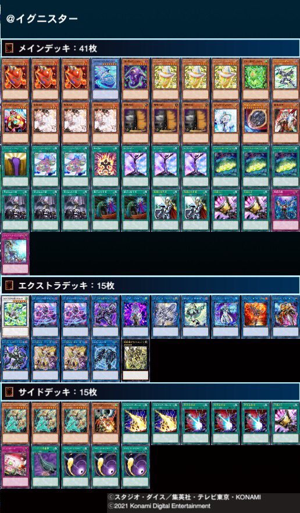

In [450]:
# Parameters
local = 'ko'
#######################################################
# Find deck path by deck_code
deck_code = '0119-001' 
dir_deck = search_deck(deck_code)
#######################################################
deck_width = 600
print(f'{deck_code} | Width of Deck         | {deck_width}')
#######################################################
img_deck = cv2.imread(dir_deck)
img_deck = imutils.resize(img_deck, width = deck_width)
img_deck = cv2.cvtColor(img_deck, cv2.COLOR_BGR2GRAY)
#######################################################
exp_card_width = deck_width/10 # change the number according to abnormal sized decks
card_min = int(exp_card_width *0.6) 
card_max = int(exp_card_width *1.4)
step = card_max-card_min+1
#######################################################
threshold = 0.75 #lower the values to include more results / increase in false positive as a drawback
card_width_list = []
for digit in db_digit_freq:
    ind = np.where(db_digit == int(digit))[0][0]
    pen = db_pen[ind]
    dir_card = f'{dir_main}/YGO_DB_Crop/{digit}.jpg'
    img_card = cv2.imread(dir_card, 0)
    if pen:
        card_widht = None
    else:
        card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
    if card_width != None:
        card_width_list.append(card_width)
#######################################################
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
    print(f'{deck_code} | Width of Card         | {card_width}')
except ZeroDivisionError:
    card_width = round_near(exp_card_width)
    print(f"{deck_code} | Width of Card; Zero Div Error | {card_width}")
print(f'-- {card_width_list} --' )
#######################################################
dup_tol = math.floor(card_width / 2)
sort_round = math.floor(card_width / 2)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################

dir_digit_manual = 'C:/ML_YGO/data/digit_manual.txt'
digit_list_manual = np.loadtxt(dir_digit_manual, dtype='str')
digit_list = digit_list_manual
print(f'{deck_code} | Cards to match        | {len(digit_list)}')
#######################################################
image = Image.open(dir_deck)
o_size = image.size
f = 300
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

## Solver

In [254]:
scale_pen = 271
scale_reg = 323
scale_param = scale_pen / scale_reg

# Solver
perf_round = 2
print(f'{deck_code} | Started Process                   | Run')
t1 = time.perf_counter()
#####################################################################
# Load images and resize for card_width 
print(f'{deck_code} | -Converting Image for {card_width:03d}         |')
img_card_list = []
for digit in digit_list:
    ind = np.where(db_digit == int(digit))[0][0]
    pen = db_pen[ind]
    if pen:
        rescale = math.floor(card_width * scale_param)
    else:
        rescale = card_width
    dir_card = f"{dir_main}/YGO_DB_Crop/{digit}.jpg"
    img_card = cv2.imread(dir_card, 0)
    img_card = imutils.resize(img_card, width = rescale)
    img_card_list.append(img_card)
print(f'{deck_code} | -Converted Image for {card_width:03d}          | { round(time.perf_counter() - t1 , perf_round)}')
#####################################################################
args = [
    [img_card, img_deck, threshold]
    for img_card in img_card_list
]
#####################################################################
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - t1 , perf_round)}")
#####################################################################
t2 = time.perf_counter()
card_loc = [item[0] for item in result]
card_pos = [item[1] for item in result]
#####################################################################
# Translator
tt = time.perf_counter()
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
print(f"{deck_code} |     Converting 1 : Raw            | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
dup_pt, dup_ind = trans_dup (zip_pt, dup_tol)
print(f"{deck_code} |     Converting 2 : Dup            | { round(time.perf_counter() - tt , perf_round)}")


tt = time.perf_counter()
group_pt, group_pos, group_digit = trans_group (dup_ind, zip_pt, zip_pos, zip_digit)
print(f"{deck_code} |     Converting 3 : Group          | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
print(f"{deck_code} |     Converting 4 : Sort           | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
sort_name = trans_name(sort_digit, local)
print(f"{deck_code} |     Converting 5 : Name           | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
sort_extra = trans_extra(sort_digit)
print(f"{deck_code} |     Converting 6 : Type           | { round(time.perf_counter() - tt , perf_round)}")

tt = time.perf_counter()
deck_list = trans_paste(sort_name, sort_extra, deck_code)
print(f"{deck_code} |     Converting 7 : Paste          | { round(time.perf_counter() - tt , perf_round)}")

print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
dir_write = f'{dir_main}/Output/single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)
print(f"{deck_code} | Finished Process in               | = { round(time.perf_counter() - t1 , perf_round)}")

0119-001 | Started Process                   | Run
0119-001 | -Converting Image for 045         |
0119-001 | -Converted Image for 045          | 0.05
0119-001 | -Finished Template Matching in    | 1.23
0119-001 |     Converting 1 : Raw            | 0.01
0119-001 |     Converting 2 : Dup            | 0.69
0119-001 |     Converting 3 : Group          | 0.0
0119-001 |     Converting 4 : Sort           | 0.01
0119-001 |     Converting 5 : Name           | 0.0
0119-001 |     Converting 6 : Type           | 0.0
0119-001 |     Converting 7 : Paste          | 0.0
0119-001 | -Finished Translating in          | 0.71
0119-001 | Finished Process in               | = 2.09


In [255]:
# Export Data
package = [deck_code, deck_width, card_width]
for i, digit in enumerate(digit_list):
    # digit = digit_list[i]
    for j in range(len(card_loc[i])):
        coord = card_loc[i][j]
        coX = coord[0]
        coY = coord[1]
        pos = card_pos[i][j]
        ind = np.where(db_digit == int(digit))[0][0]
        name = np.asarray(df[f"Name_{local.upper()}"])[ind]
        package.append(f'{coX}, {coY}, {digit}, {pos}, {name}')

dir_write = f'{dir_main}\Output\package.txt'
with open(dir_write, 'w', encoding="utf-8") as fp:
    for item in package:
        fp.write("%s\n" % item)

# Compare

In [504]:
card_width = 40
digit_list = db_digit_min
img_card_list = []
for digit in digit_list:
    dir_card = f"{dir_main}/YGO_DB/{digit}.jpg"
    img_card = cv2.imread(dir_card, 0)
    img_card = imutils.resize(img_card, width = card_width)
    img_card = cv2.normalize(img_card, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    img_card_list.append(img_card)

In [505]:
arr1 = img_card_list[0]
arr2 = img_card_list[1]

In [506]:
diff = arr1 - arr2
mse = np.mean(diff ** 2)
print(mse)

0.24698275862068966


In [507]:
mse_list = []
for i in range(len(img_card_list)):
    img_card_1 = img_card_list[0]
    img_card_2 = img_card_list[i]
    diff = img_card_1 - img_card_2
    mse = round(np.mean(diff ** 2),2)
    mse_list.append(mse)

In [508]:
print(mse_list)

[0.0, 0.25, 0.22, 0.21, 0.21, 0.17, 0.24, 0.21, 0.29, 0.23, 0.21, 0.2, 0.35, 0.32, 0.21, 0.25, 0.27, 0.23, 0.27, 0.27, 0.23, 0.29, 0.32, 0.19, 0.2, 0.28, 0.23, 0.23, 0.18, 0.23, 0.19, 0.18, 0.22, 0.22, 0.3, 0.27, 0.26, 0.25, 0.25, 0.27, 0.22, 0.24, 0.33, 0.25, 0.32, 0.37, 0.28, 0.29, 0.28, 0.26, 0.29, 0.39, 0.33, 0.29, 0.33, 0.27, 0.24, 0.22, 0.38, 0.3, 0.3, 0.27, 0.32, 0.31, 0.26, 0.26, 0.25, 0.18, 0.25, 0.21, 0.19, 0.25, 0.25, 0.25, 0.28, 0.22, 0.23, 0.3, 0.3, 0.33, 0.25, 0.26, 0.27, 0.24, 0.24, 0.24, 0.24, 0.27, 0.28, 0.31, 0.32, 0.27, 0.3, 0.24, 0.3, 0.28, 0.26, 0.32, 0.36, 0.29, 0.3, 0.26, 0.35, 0.24, 0.24, 0.27, 0.26, 0.23, 0.28, 0.37, 0.24, 0.21, 0.23, 0.34, 0.27, 0.24, 0.26, 0.34, 0.26, 0.28, 0.29, 0.3, 0.35, 0.32, 0.23, 0.25, 0.2, 0.32, 0.29, 0.21, 0.37, 0.19, 0.29, 0.23, 0.21, 0.38, 0.27, 0.35, 0.2, 0.23, 0.22, 0.25, 0.25, 0.3, 0.3, 0.28, 0.27, 0.23, 0.25, 0.38, 0.3, 0.19, 0.38, 0.37, 0.27, 0.33, 0.34, 0.33, 0.28, 0.3, 0.18, 0.27, 0.37, 0.24, 0.22, 0.31, 0.27, 0.21, 0.34, 0.3

In [ ]:
mse_list = []
for i in range(len(img_card_list)):
    mse_temp = []
    for j in range(len(img_card_list)):
        diff = img_card_list[i] - img_card_list[j]
        mse = round(np.mean(diff ** 2),2)
        mse_temp.append(mse)
    mse_list.append(mse_temp)

In [510]:
mse_list = np.zeros((len(img_card_list), len(img_card_list)))
for i in range(len(img_card_list)):
    for j in range(i, len(img_card_list)):
        diff = img_card_list[i] - img_card_list[j]
        mse = round(np.mean(diff ** 2), 2)
        mse_list[i,j] = mse
        mse_list[j,i] = mse